In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts

import matplotlib.pyplot as plt

from scipy.stats import shapiro
from statsmodels.stats.multitest import multipletests

### Drafts

In [14]:
np.unique(df['atom.tcr.contact'])

array(['C', 'CB', 'CD', 'CD1', 'CD2', 'CE', 'CE1', 'CE2', 'CE3', 'CG',
       'CG1', 'CG2', 'CZ', 'CZ2', 'CZ3', 'ND2', 'NE1', 'NE2', 'NONE', 'O',
       'OD1', 'OD2', 'OE1', 'OG', 'OG1', 'none'], dtype=object)

In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df.loc[18])

resname.peptide                                            A
resn.mut.to                                                P
pdb.id                  5d2l_TRB_CASSQTQPWETQYF_min_repacked
chain.type                                               TRB
cdr3.from                                     CASSQTQLWETQYF
cdr3.to                                       CASSQTQPWETQYF
mutation.type                               Mutated_repacked
dEnergy                                             -0.50614
abs.dEnergy                                          0.50614
energy.type                                      patch_small
min.min.distance                                    3.717806
v.segm                                            TRBV7-2*01
v.segm.vdjdb                                      TRBV7-2*01
j.segm                                            TRBJ2-5*01
j.segm.vdjdb                                      TRBJ2-5*01
peptide                                            NLVPMVATV
antigen.epitope         

### Useful functions

In [46]:
def filter_by_features(contacts_df,
                       energy_type,
                       mutation_type,
                       # contacting_parts,
                       chain_type='both',
                       clean_missing_energy=True):
    """
    Filters the contacts table by specified features

    Parameters
    ----------
    contacts_df : DataFrame
        Contacts table
    energy_type : str
        
    mutation_type : str
        "Mutated" or "Mutated_repacked"
    contacting_parts : str
        _description_
    chain_type : str, optional
        _description_, by default 'both'
    clean_missing_energy : bool, optional
        If True, deletes contacts with missing energy, by default True

    Returns
    -------
    filtered_df : DataFrame
        Filtered contacts
    """
    filtered_df = contacts_df.copy()
    filtered_df = filtered_df[filtered_df['energy.type'] == energy_type].drop('energy.type', 1)
    filtered_df = filtered_df[filtered_df['mutation.type'] == mutation_type].drop('mutation.type', 1)
    if clean_missing_energy: 
        filtered_df = filtered_df[filtered_df['byres.energy'] != 'none']
        filtered_df.loc[:,'byres.energy'] = filtered_df['byres.energy'].astype(np.float64)
    
    if chain_type != 'both':
        filtered_df = filtered_df[filtered_df['chain.type'] == chain_type]
        
    filtered_df = filtered_df[
        (filtered_df['rin.contact.part'] == 'SC_SC') |                                                                # both side chains or
        (filtered_df['resn.mut.to'] == 'G') & filtered_df['rin.contact.part'].apply(lambda s: s.startswith('MC')) |   # cdr3 glycine main chain or
        (filtered_df['resname.peptide'] == 'G') & filtered_df['rin.contact.part'].apply(lambda s: s.endswith('MC'))   # peptide glycine main chain
    ]
        
    filtered_df.reset_index(inplace=True)

    return filtered_df

In [55]:
def weights_by_enegy(energy):
    ENERGY_THRESHOLD = -3
    
    # kT = ??? Units of energy are necessary for proper scaling
    energy[energy < ENERGY_THRESHOLD] = ENERGY_THRESHOLD    # Cut off outliers
    return np.exp(-energy)

### Reading and filtering data

In [63]:
# Reading data
contacts_df = pd.read_csv('2022_modelled_structures_descriptors_FULL.csv')
contacts_df.drop('Unnamed: 0', 1, inplace=True)    # Removing artefact column

In [64]:
# Extracting descriptor names
cdr3_indices = np.hstack((contacts_df.columns[-94:-89], contacts_df.columns[-84:-42]))
peptide_indices = np.hstack((contacts_df.columns[-89:-84], contacts_df.columns[-42:]))

index_names = np.array([name[5:] for name in cdr3_indices])

<AxesSubplot:>

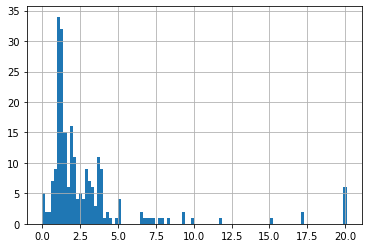

In [65]:
# Filtering and adding weights
contacts_filtered = filter_by_features(contacts_df, energy_type='OLD', mutation_type='Mutated_repacked', chain_type='both')
contacts_filtered['weights'] = weights_by_enegy(contacts_filtered['byres.energy'])

contacts_filtered['weights'].hist(bins=100)

### Defining groups by properties

In [72]:
index_nature = pd.read_excel('indices.xlsx', index_col='index_name')
indices = index_nature.index
index_nature = ~index_nature.isna()

for prop in index_nature.columns:
    print('\t', prop)
    print()
    for ind in index_nature.index[index_nature[prop]]:
        print(ind)
    print()

	 Hydrophobicity

Z1
PP2
F1
VHSE1
VHSE2
Blos1
KF4
KF10

	 Steric_properties

atcley.ms
Z2
F3
VHSE3
VHSE4
Blos1
Blos2
Blos3
KF2

	 Electronic_properties

atcley.pah
atcley.ec
Z3
PP1
F6
VHSE5
VHSE6
VHSE7
VHSE8

	 Structure

atcley.pss
F2
Blos1
Blos3
KF1
KF3
KF5
KF8



### PCA analysis

In [73]:
from sklearn.decomposition import PCA

In [128]:
N_COMPONENTS = 10

descriptor_names = np.hstack((cdr3_indices, peptide_indices))
descriptors = contacts_filtered[descriptor_names]
descriptors /= descriptors.std(axis=0)    # normalization of descriptor variance

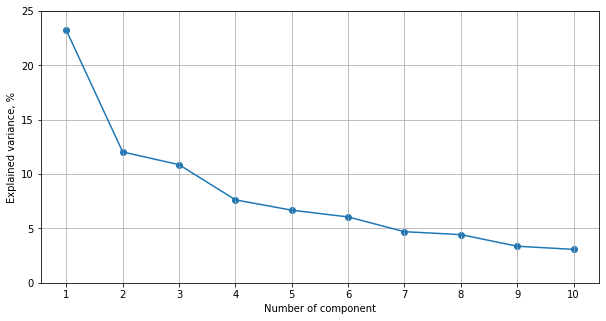

In [132]:
pca = PCA(n_components=N_COMPONENTS)
pca.fit(descriptors)

explained_variance_percent = pca.explained_variance_ratio_ * 100
component_number = np.arange(1, N_COMPONENTS+1)

plt.figure(figsize=(10,5))
plt.plot(component_number, explained_variance_percent)
plt.scatter(component_number, explained_variance_percent)
plt.xticks(component_number)
plt.xlabel('Number of component')
plt.ylabel('Explained variance, %')
plt.ylim(0, 25)
plt.grid()
plt.show()

In [170]:
components = pd.DataFrame(pca.components_ * pca.explained_variance_[:,None], columns=descriptor_names)    # Considering components length
components_properties = pd.DataFrame(index=components.index, columns=index_nature.columns)

for prop in index_nature.columns:
    prop_columns = descriptor_names[np.hstack((index_nature[prop], index_nature[prop]))]
    prop_df = components[prop_columns]
    components_properties.loc[:,prop] = np.linalg.norm(prop_df, axis=1)
    
# components_properties /= components_properties.sum(axis=1).values[:,None]
components_properties

,Hydrophobicity,Steric_properties,Electronic_properties,Structure
0,11.997919,11.681689,8.127548,7.645815
1,4.225820,7.006831,3.706442,3.020024
2,5.654195,4.279987,5.733506,4.393841
3,2.476264,2.018049,3.697371,2.929497
4,1.511386,2.268003,2.718730,2.970217
5,1.697068,1.943019,3.096376,2.523035
6,0.757400,1.250716,1.822395,2.561333
7,1.078784,1.298098,1.551389,1.638017
8,0.851241,0.874647,1.565099,1.681341
9,0.564721,0.905156,1.027353,1.340607


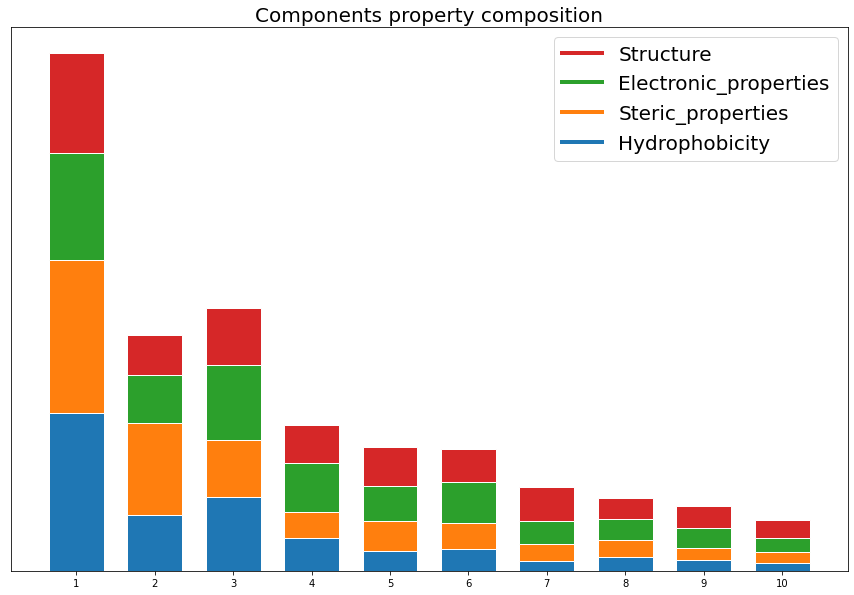

In [186]:
from matplotlib.lines import Line2D

plt.figure(figsize=(15,10))
plt.xticks(component_number)
plt.yticks([])

bottom = np.zeros(N_COMPONENTS)
custom_lines = []
i = 0
for prop in index_nature.columns:
    layer_heigth = components_properties[prop] #* explained_variance_percent
    plt.bar(component_number, layer_heigth, bottom=bottom, edgecolor='white', width=0.7, color=f'C{i}')
    custom_lines.append(Line2D([0], [0], color=f'C{i}', lw=4))
    bottom += layer_heigth
    i += 1
    
plt.legend(custom_lines[::-1], index_nature.columns[::-1], fontsize=20)
plt.title('Components property composition', fontsize=20)
plt.show()

### Correlation analysis

In [17]:
def pairwise_correlation_of_indices(cdr3_indices, peptide_indices, df, method='pearson'):
    return (df[np.hstack((cdr3_indices, peptide_indices))]
            .corr(method=method)
            .loc[cdr3_indices, peptide_indices])

In [18]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr_w(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def pairwise_correlation_of_indices_weighted(cdr3_indices, peptide_indices, 
                                             weights, df):
    corr_df = pd.DataFrame(index=cdr3_indices, columns=peptide_indices, dtype=np.float32)
    W = df[weights]
    for cdr_ind in cdr3_indices:
        for pep_ind in peptide_indices:
            corr_df.loc[cdr_ind, pep_ind] = corr_w(
                df[cdr_ind],
                df[pep_ind],
                df[weights]
            )
    
    return corr_df

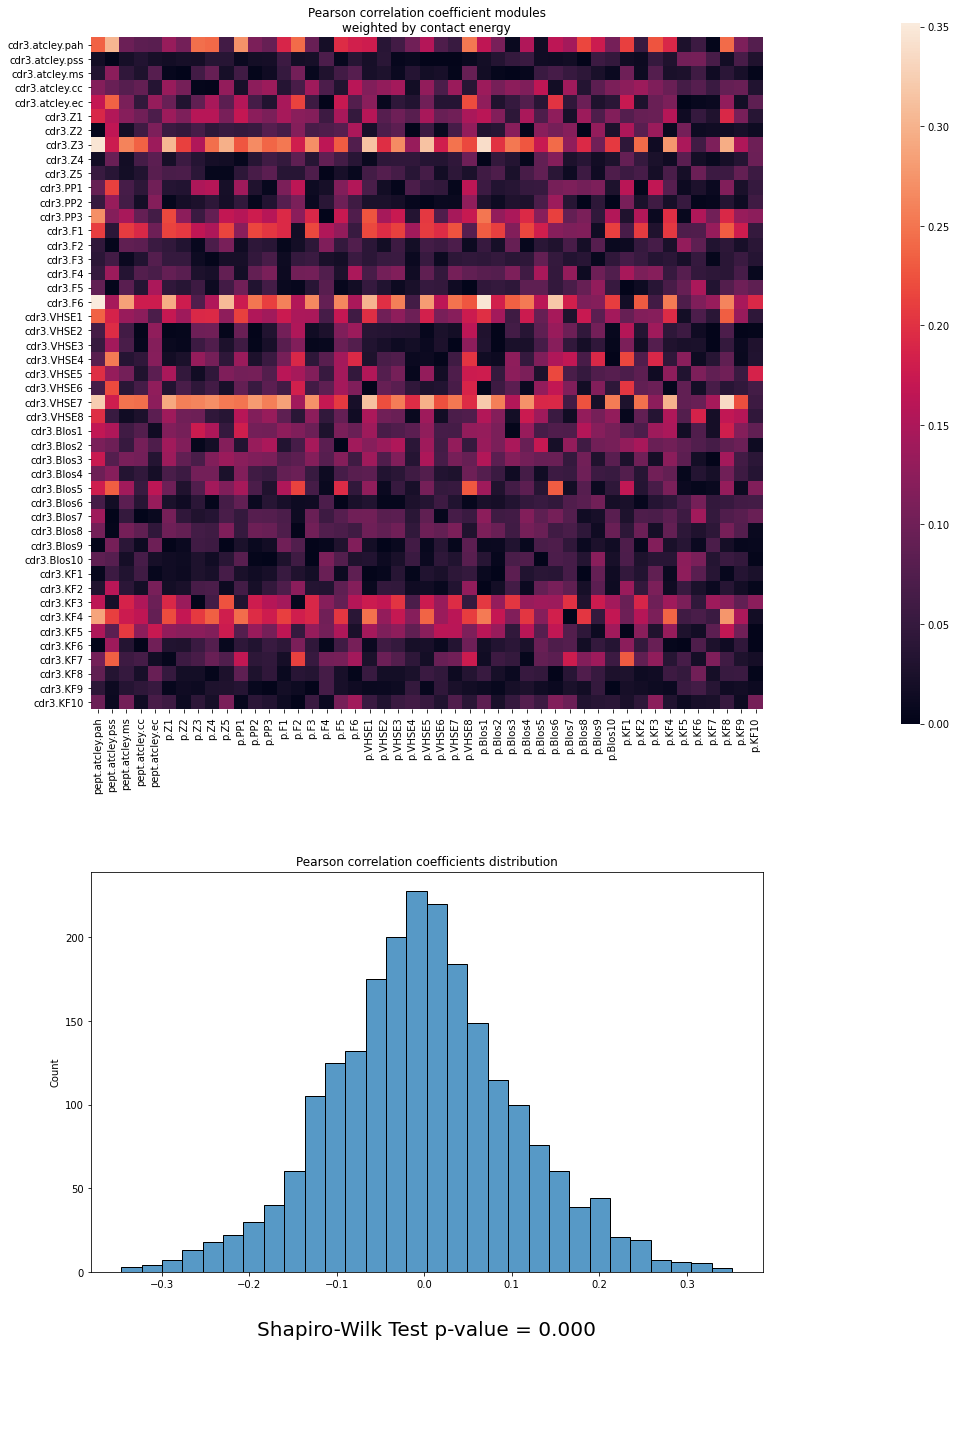

In [82]:
df = df_mutated_repacked_SC_SC

TEXT_SIZE = 25

fig, ax = plt.subplots(3, 2,
                       figsize=(14.4, 22.2),
                       gridspec_kw={'width_ratios': [7, 0.2],
                                    'height_ratios': [7, 4, 0.1]})
    
i = 0
ax_prop = ax[:,i]

corr = pairwise_correlation_of_indices(
    cdr3_indices,
    peptide_indices,
    df)

sns.heatmap(corr.abs(), vmin=0, square=True, 
            ax=ax_prop[0], cbar_ax=ax[0,-1])
ax_prop[0].set_title('Pearson correlation coefficient modules\nweighted by contact energy')

sns.histplot(corr.values.flatten(), bins=30, ax=ax_prop[1])
ax_prop[1].set_title('Pearson correlation coefficients distribution')

ax_prop[2].text(0.5, 10, 
                f'Shapiro-Wilk Test p-value = {shapiro(corr.values.flatten())[1]:.3f}',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=TEXT_SIZE-5,
               )
ax_prop[2].set_axis_off()
    
ax[1,-1].set_axis_off()
ax[2,-1].set_axis_off()
    
# fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.02, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

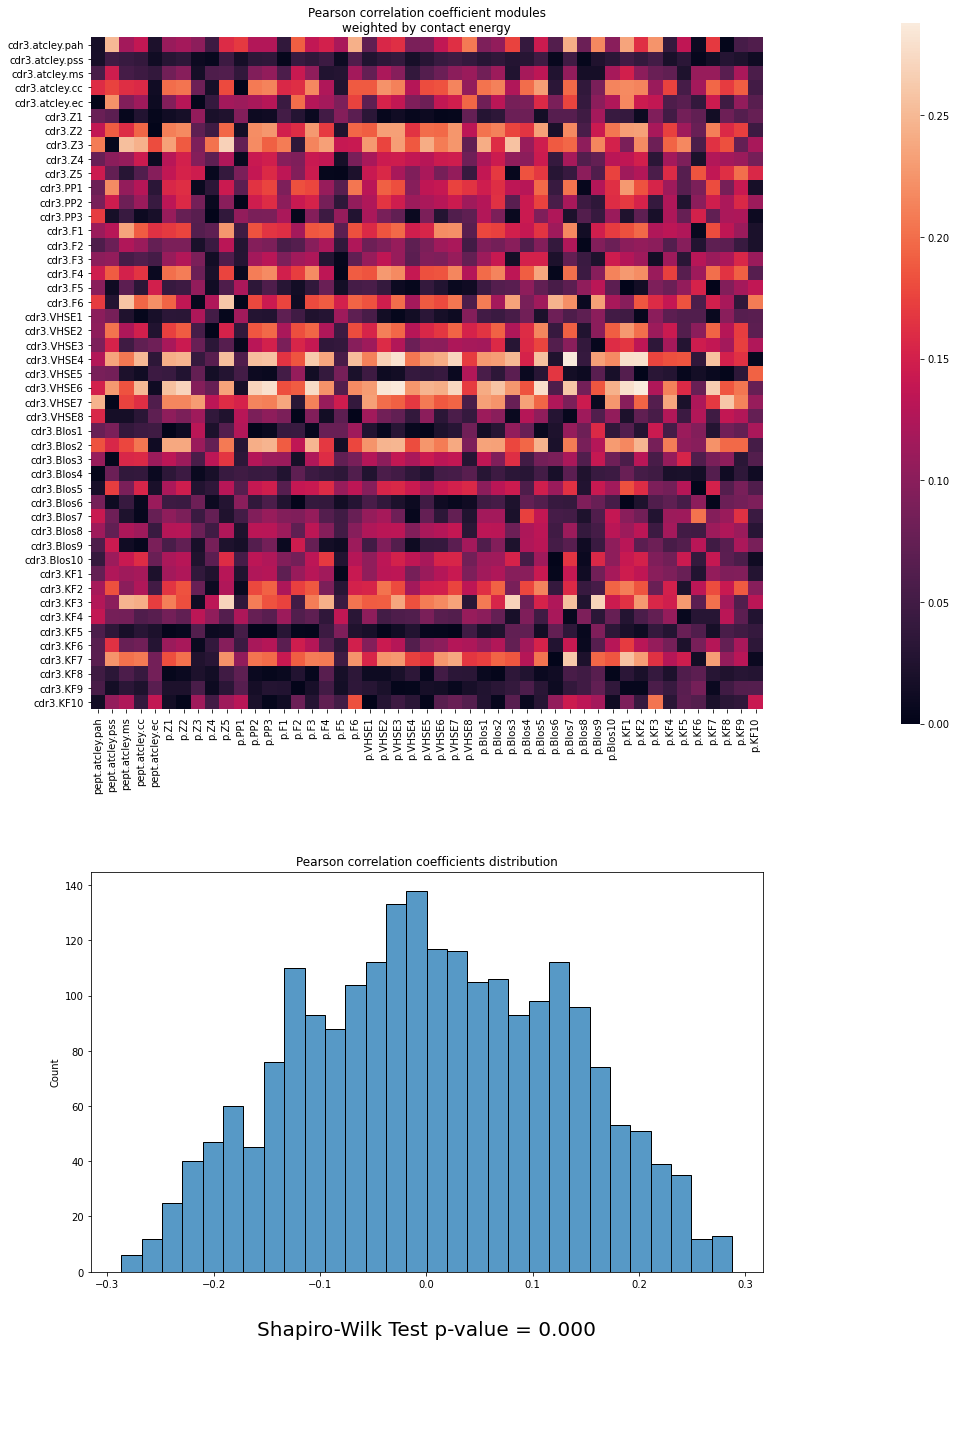

In [83]:
df = df_mutated_repacked_SC_SC

TEXT_SIZE = 25

fig, ax = plt.subplots(3, 2,
                       figsize=(14.4, 22.2),
                       gridspec_kw={'width_ratios': [7, 0.2],
                                    'height_ratios': [7, 4, 0.1]})
    
i = 0
ax_prop = ax[:,i]

corr = pairwise_correlation_of_indices_weighted(
    cdr3_indices,
    peptide_indices,
    'weights',
    df)

sns.heatmap(corr.abs(), vmin=0, square=True, 
            ax=ax_prop[0], cbar_ax=ax[0,-1])
ax_prop[0].set_title('Pearson correlation coefficient modules\nweighted by contact energy')

sns.histplot(corr.values.flatten(), bins=30, ax=ax_prop[1])
ax_prop[1].set_title('Pearson correlation coefficients distribution')

ax_prop[2].text(0.5, 10, 
                f'Shapiro-Wilk Test p-value = {shapiro(corr.values.flatten())[1]:.3f}',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=TEXT_SIZE-5,
               )
ax_prop[2].set_axis_off()
    
ax[1,-1].set_axis_off()
ax[2,-1].set_axis_off()
    
# fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.02, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

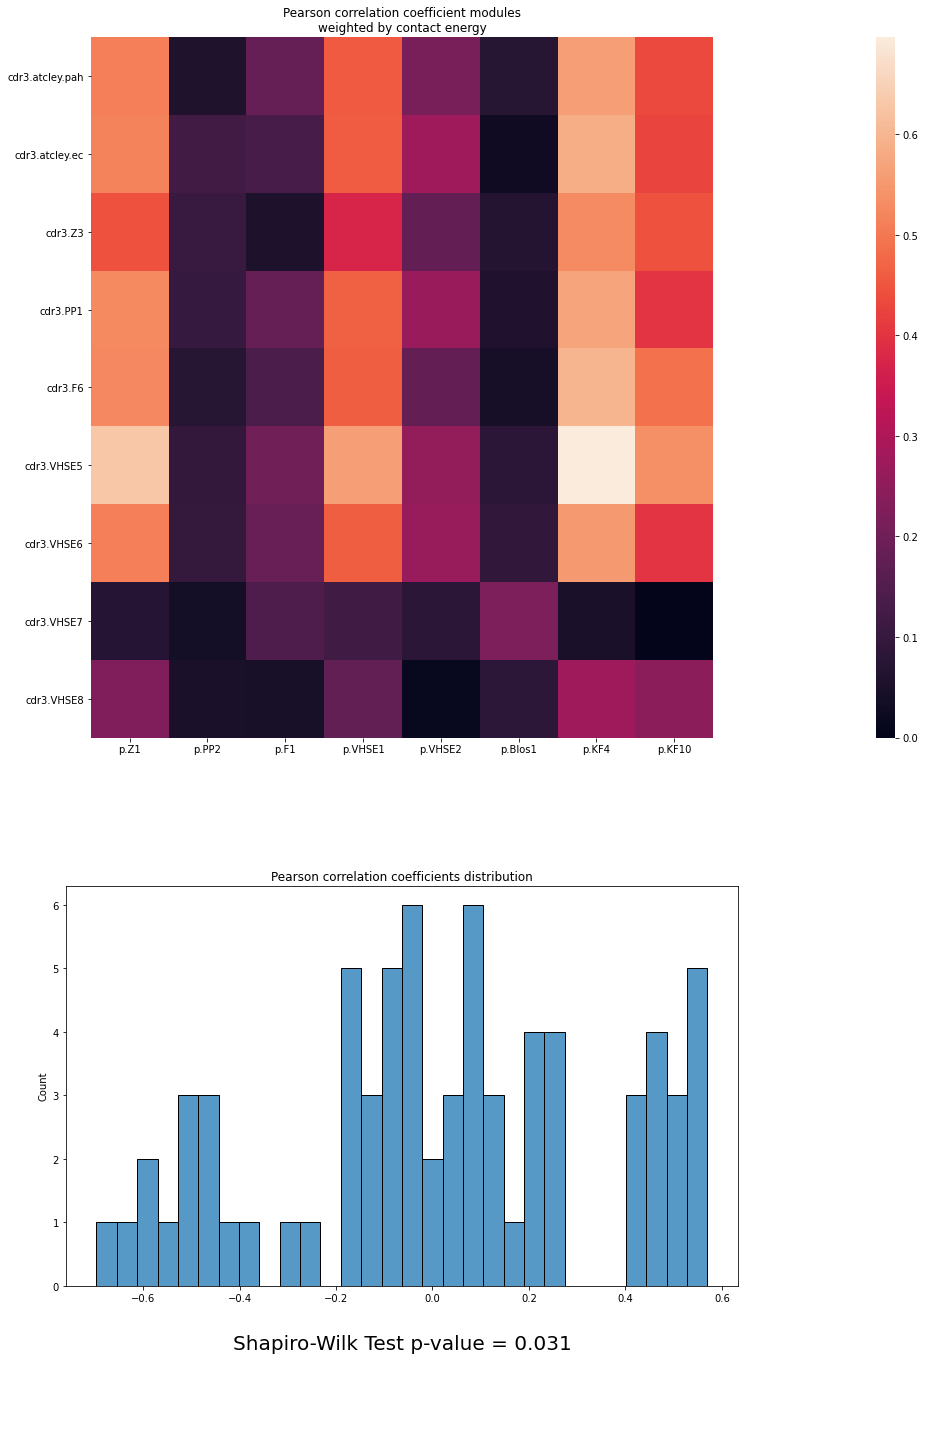

In [63]:
df = df_mutated_repacked_SC_SC

TEXT_SIZE = 25

fig, ax = plt.subplots(3, 2,
                       figsize=(14.4, 22.2),
                       gridspec_kw={'width_ratios': [7, 0.2],
                                    'height_ratios': [7, 4, 0.1]})
    
i = 0
ax_prop = ax[:,i]

corr = pairwise_correlation_of_indices_weighted(
    cdr3_indices[index_nature['Electronic_properties']],
    peptide_indices[index_nature['Hydrophobicity']],
    'weights',
    df)

sns.heatmap(corr.abs(), vmin=0, square=True, 
            ax=ax_prop[0], cbar_ax=ax[0,-1])
ax_prop[0].set_title('Pearson correlation coefficient modules\nweighted by contact energy')

sns.histplot(corr.values.flatten(), bins=30, ax=ax_prop[1])
ax_prop[1].set_title('Pearson correlation coefficients distribution')

ax_prop[2].text(0.5, 10, 
                f'Shapiro-Wilk Test p-value = {shapiro(corr.values.flatten())[1]:.3f}',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=TEXT_SIZE-5,
               )
ax_prop[2].set_axis_off()
    
ax[1,-1].set_axis_off()
ax[2,-1].set_axis_off()
    
# fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.02, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

Hydrophobicity
Sign: 0.0
-0.17682818 0.21050256

Steric_properties
Sign: 0.0
-0.24951407 0.28014106

Electronic_properties
Sign: 0.0
-0.2722527 0.24634455

Structure
Sign: 0.0
-0.22797188 0.26938516



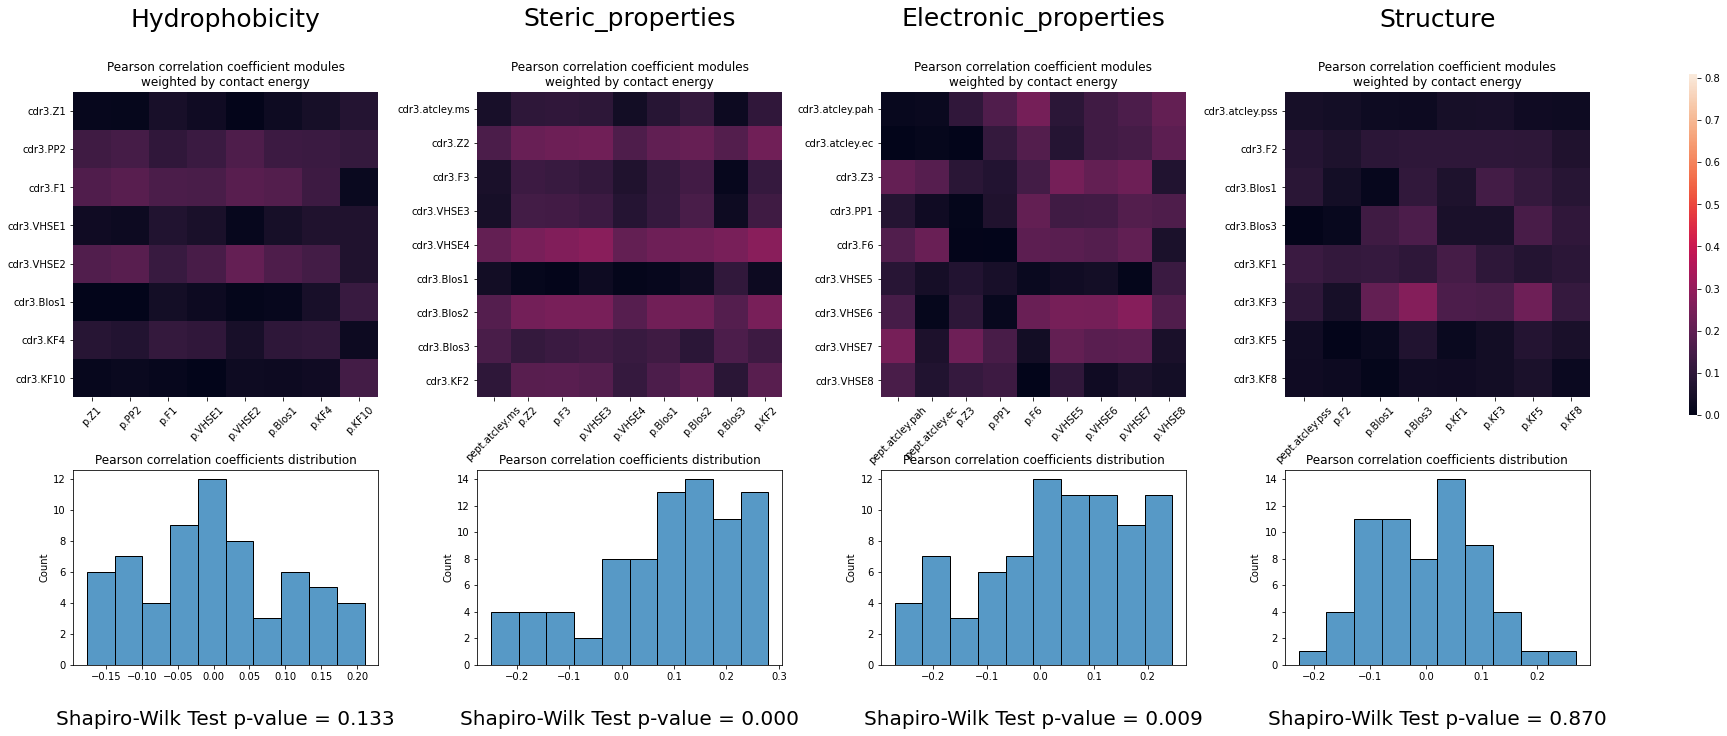

In [69]:
df = df_mutated_repacked_SC_SC
alpha = 0.05

TEXT_SIZE = 25

fig, ax = plt.subplots(4, index_nature.columns.size + 1,
                       figsize=(28.2, 11.2),
                       gridspec_kw={'width_ratios': [7, 7, 7, 7, 0.2],
                                    'height_ratios': [0.1, 7, 4, 0.1]})

i = 0
for prop in index_nature.columns:
    
    ax_prop = ax[:,i]
    
    ax_prop[0].text(0.5, 0, 
                    prop,
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=TEXT_SIZE,
                   )
    ax_prop[0].set_axis_off()
    
    corr = pairwise_correlation_of_indices_weighted(
        cdr3_indices[index_nature[prop]],
        peptide_indices[index_nature[prop]],
        'weights',
        df)
    
    corr_values = corr.values.flatten()
    N = corr_values.size

    t_stats = corr_values * np.sqrt((N - 2) / (1 - corr_values**2))
    corr_p_values = 1 - sts.t.cdf(np.abs(t_stats), N-2)

    
    print(prop)
    print('Sign:', multipletests(corr_p_values, alpha/2)[0].mean())
    print(corr_values.min(), corr_values.max())
    print()
    
    
#     print(corr.abs().values.max())
    
    sns.heatmap(corr.abs(), vmin=0, vmax=0.809, square=True, 
                ax=ax_prop[1], cbar_ax=ax[1,-1])
    ax_prop[1].set_title('Pearson correlation coefficient modules\nweighted by contact energy')
    ax_prop[1].tick_params(axis='x', rotation=45)
    
    sns.histplot(corr.values.flatten(), bins=10, ax=ax_prop[2])
    ax_prop[2].set_title('Pearson correlation coefficients distribution')
    
    ax_prop[3].text(0.5, 1, 
                    f'Shapiro-Wilk Test p-value = {shapiro(corr.values.flatten())[1]:.3f}',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=TEXT_SIZE-5,
                   )
    ax_prop[3].set_axis_off()
    
    i += 1
    
ax[0,-1].set_axis_off()
ax[2,-1].set_axis_off()
ax[3,-1].set_axis_off()
    
# fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.02, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

Hydrophobicity
Sign: 0.421875
-0.54201937 0.56606853

Steric_properties
Sign: 0.024691358024691357
-0.40242174 0.42212623

Electronic_properties
Sign: 0.43209876543209874
-0.8083747 0.779371

Structure
Sign: 0.046875
-0.47384128 0.552911



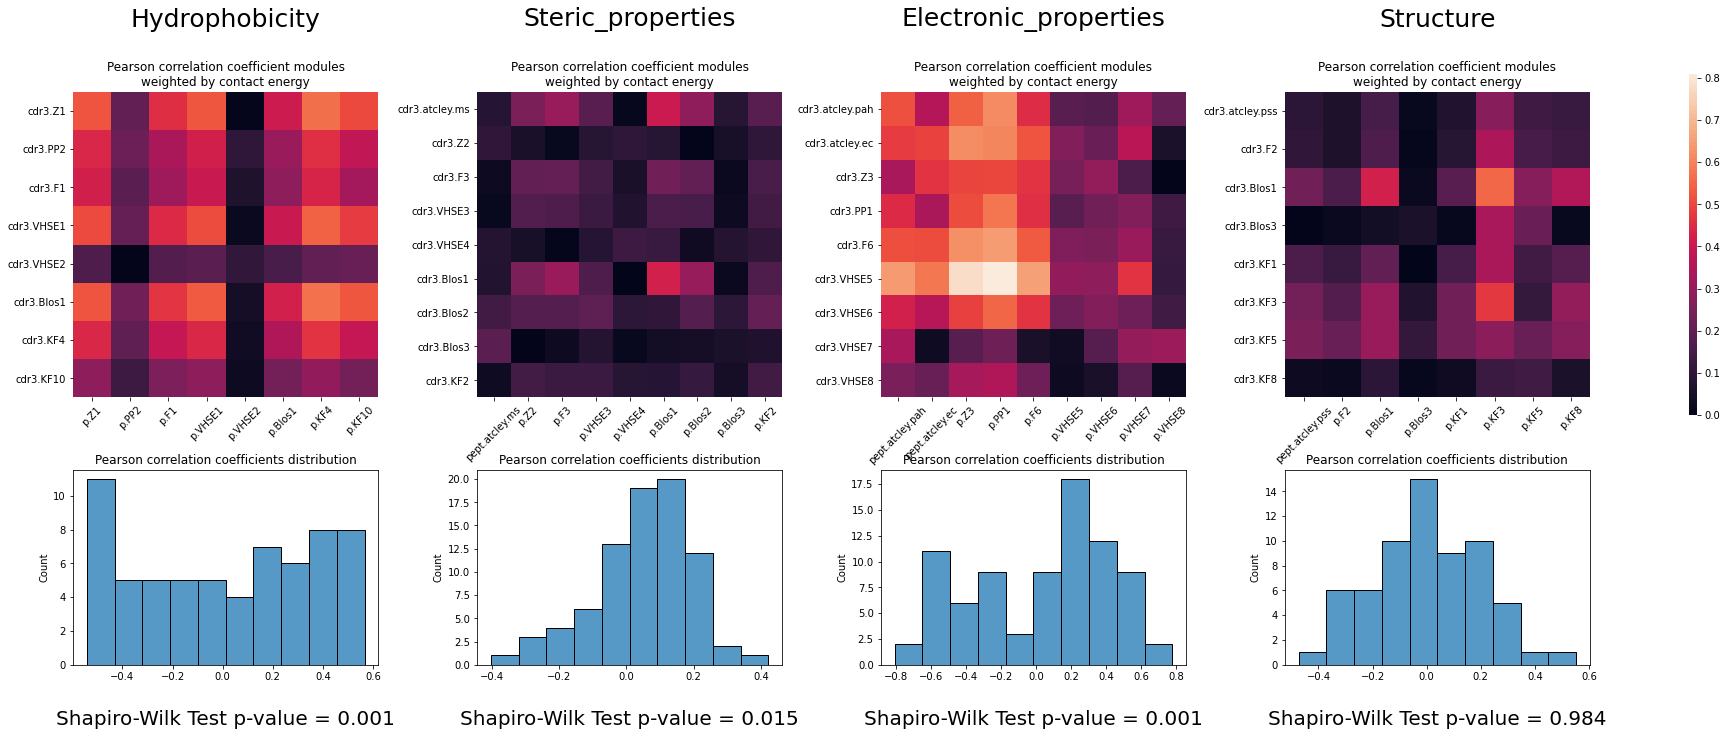

In [34]:
df = df_mutated_repacked_SC_SC
alpha = 0.05

TEXT_SIZE = 25

fig, ax = plt.subplots(4, index_nature.columns.size + 1,
                       figsize=(28.2, 11.2),
                       gridspec_kw={'width_ratios': [7, 7, 7, 7, 0.2],
                                    'height_ratios': [0.1, 7, 4, 0.1]})

i = 0
for prop_i in index_nature.columns:
    for prop_j in index_nature.columns:
    
        ax_prop = ax[:,i]

        ax_prop[0].text(0.5, 0, 
                        prop_i + ' - ' + prop_j,
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=TEXT_SIZE,
                       )
        ax_prop[0].set_axis_off()

        corr = pairwise_correlation_of_indices_weighted(
            cdr3_indices[index_nature[prop]],
            peptide_indices[index_nature[prop]],
            'weights',
            df)

        corr_values = corr.values.flatten()
        N = corr_values.size

        t_stats = corr_values * np.sqrt((N - 2) / (1 - corr_values**2))
        corr_p_values = 1 - sts.t.cdf(np.abs(t_stats), N-2)


        print(prop)
        print('Sign:', multipletests(corr_p_values, alpha/2)[0].mean())
        print(corr_values.min(), corr_values.max())
        print()


    #     print(corr.abs().values.max())

        sns.heatmap(corr.abs(), vmin=0, vmax=0.809, square=True, 
                    ax=ax_prop[1], cbar_ax=ax[1,-1])
        ax_prop[1].set_title('Pearson correlation coefficient modules\nweighted by contact energy')
        ax_prop[1].tick_params(axis='x', rotation=45)

        sns.histplot(corr.values.flatten(), bins=10, ax=ax_prop[2])
        ax_prop[2].set_title('Pearson correlation coefficients distribution')

        ax_prop[3].text(0.5, 1, 
                        f'Shapiro-Wilk Test p-value = {shapiro(corr.values.flatten())[1]:.3f}',
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=TEXT_SIZE-5,
                       )
        ax_prop[3].set_axis_off()

        i += 1
    
ax[0,-1].set_axis_off()
ax[2,-1].set_axis_off()
ax[3,-1].set_axis_off()
    
# fig.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.02, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()